# Trader Joe's

In [108]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import us
from bs4 import BeautifulSoup

In [184]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

In [110]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


---

In [132]:
import requests

headers = {
    "authority": "alphaapi.brandify.com",
    "accept": "application/json, text/plain, */*",
    "accept-language": "en-US,en;q=0.9,es;q=0.8",
    "content-type": "application/json;charset=UTF-8",
    "origin": "https://www.traderjoes.com",
    "referer": "https://www.traderjoes.com/",
    "sec-ch-ua": '".Not/A)Brand";v="99", "Google Chrome";v="103", "Chromium";v="103"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"macOS"',
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "cross-site",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36",
}

json_data = {
    "request": {
        "appkey": "8BC3433A-60FC-11E3-991D-B2EE0C70A832",
        "formdata": {
            "geoip": False,
            "dataview": "store_default",
            "limit": 1000,
            "geolocs": {
                "geoloc": [
                    {
                        "addressline": "90066",
                        "country": "US",
                        "latitude": "",
                        "longitude": "",
                    },
                ],
            },
            "searchradius": "5000",
            "where": {
                "warehouse": {
                    "distinctfrom": "1",
                },
            },
            "false": "0",
        },
    },
}

response = requests.post(
    "https://alphaapi.brandify.com/rest/locatorsearch", headers=headers, json=json_data
)

In [177]:
src = pd.DataFrame(response.json()["response"]["collection"])

In [178]:
len(src)

544

In [185]:
df = src[
    [
        "uid",
        "name",
        "address1",
        "city",
        "state",
        "postalcode",
        "phone",
        "latitude",
        "longitude",
        "beer",
        "liquor",
        "wineshop",
        "regions",
        "locationimage",
    ]
].copy()

In [186]:
df.rename(columns={"address1": "address"}, inplace=True)

In [187]:
df.head()

,uid,name,address,city,state,postalcode,phone,latitude,longitude,beer,liquor,wineshop,regions,locationimage
0,1429860783,Trader Joe's West Los Angeles - Sepulveda (119),3456 S Sepulveda Blvd,Los Angeles,CA,90034,310-836-2458,34.020480,-118.422106,Yes,Yes,None,WestSide/SouthBay,https://contentstatic.com/0b7f45f8-fb2a-4177-9ced-4daea8943088.jpeg
1,-2132335040,Trader Joe's Marina Del Rey (205),4675 Admiralty Way,Marina Del Rey,CA,90292,310-301-4461,33.979559,-118.441227,Yes,Yes,None,WestSide/SouthBay,https://contentstatic.com/d6bf8836-e5b6-496d-9df3-6dc19626c264.jpeg
2,1429860675,Trader Joe's West Los Angeles (7),10850 National Blvd,Los Angeles,CA,90064,310-470-1917,34.030059,-118.421482,Yes,Yes,None,WestSide/SouthBay,https://contentstatic.com/6319e1ed-9962-4f18-a3f9-aa58d204679e.jpeg
3,1429860674,Trader Joe's Santa Monica (6),3212 Pico Blvd,Santa Monica,CA,90405,310-581-0253,34.026355,-118.455765,Yes,Yes,None,WestSide/SouthBay,https://contentstatic.com/8b7739b2-1843-4d6c-ac32-a2e02a030c20.jpeg
4,232488745,Trader Joe's Culver City (251),6150 Slauson Ave,Culver City,CA,90230,310-313-0441,33.988010,-118.392850,Yes,Yes,None,WestSide/SouthBay,https://contentstatic.com/5d5919b0-b9f2-42a8-9e81-ec558fd02ed0.jpeg


## Geography

#### Make it a geodataframe

In [172]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [204]:
locations_gdf = gdf.set_crs("EPSG:4326").copy()

#### Counties

In [188]:
counties = gpd.read_file(
    "/Users/stiles/data/gis/usa_counties_esri_simple_mainland.geojson"
)

In [198]:
counties_gdf = counties[
    [
        "fid",
        "name",
        "state_name",
        "state_fips",
        "cnty_fips",
        "fips",
        "population",
        "pop_sqmi",
        "pop2010",
        "pop10_sqmi",
        "white",
        "black",
        "ameri_es",
        "asian",
        "hawn_pi",
        "hispanic",
        "other",
        "mult_race",
        "geometry",
    ]
].copy()

<AxesSubplot:>

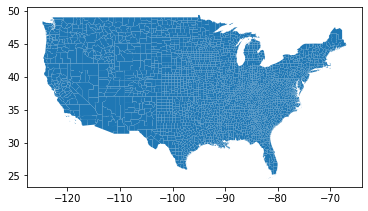

In [199]:
counties_gdf.plot()

In [206]:
tj_locations_counties = locations_gdf.sjoin(counties, how="left", predicate="within")

In [212]:
tj_locations_counties.head()

,uid,name_left,address,opendate,city,state,postalcode,country,phone,latitude,longitude,hours,beer,liquor,wineshop,regions,locationimage,geometry,index_right,fid,name_right,state_name,state_fips,cnty_fips,fips,population,pop_sqmi,pop2010,pop10_sqmi,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,males,females,age_under5,age_5_9,age_10_14,age_15_19,age_20_24,age_25_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,age_85_up,med_age,med_age_m,med_age_f,households,ave_hh_sz,hsehld_1_m,hsehld_1_f,marhh_chd,marhh_no_c,mhh_child,fhh_child,families,ave_fam_sz,hse_units,vacant,owner_occ,renter_occ,no_farms12,ave_size12,crop_acr12,ave_sale12,sqmi,no_farms17,ave_size17,crop_acr17,ave_sale17,shape_leng,shape_length,shape_area
0,1429860783,Trader Joe's West Los Angeles - Sepulveda (119),3456 S Sepulveda Blvd,None,Los Angeles,CA,90034,US,310-836-2458,34.020480,-118.422106,8AM - 9PM (Mon-Sun),Yes,Yes,None,WestSide/SouthBay,https://contentstatic.com/0b7f45f8-fb2a-4177-9ced-4daea8943088.jpeg,POINT (-118.42211 34.02048),175,204,Los Angeles County,California,06,037,06037,10173432,2490.4,9818605,2402.3,4936599,856874,72828,1346865,26094,4687889,2140632,438713,4839654,4978951,645793,633690,678845,753630,752788,1475731,1430326,1368947,1013156,568470,345603,151626,34.8,33.6,35.9,3241204,2.98,360530,424398,790374,690291,115984,296976,2194080,3.58,3445076,203872,1544749,1696455,1294,71,59556,149225,4085.07,1035,56,29624,149380,8.832223,8.832223,1.036378
1,-2132335040,Trader Joe's Marina Del Rey (205),4675 Admiralty Way,None,Marina Del Rey,CA,90292,US,310-301-4461,33.979559,-118.441227,8AM - 9PM (Mon-Sun),Yes,Yes,None,WestSide/SouthBay,https://contentstatic.com/d6bf8836-e5b6-496d-9df3-6dc19626c264.jpeg,POINT (-118.44123 33.97956),175,204,Los Angeles County,California,06,037,06037,10173432,2490.4,9818605,2402.3,4936599,856874,72828,1346865,26094,4687889,2140632,438713,4839654,4978951,645793,633690,678845,753630,752788,1475731,1430326,1368947,1013156,568470,345603,151626,34.8,33.6,35.9,3241204,2.98,360530,424398,790374,690291,115984,296976,2194080,3.58,3445076,203872,1544749,1696455,1294,71,59556,149225,4085.07,1035,56,29624,149380,8.832223,8.832223,1.036378
2,1429860675,Trader Joe's West Los Angeles (7),10850 National Blvd,None,Los Angeles,CA,90064,US,310-470-1917,34.030059,-118.421482,8AM - 9PM (Mon-Sun),Yes,Yes,None,WestSide/SouthBay,https://contentstatic.com/6319e1ed-9962-4f18-a3f9-aa58d204679e.jpeg,POINT (-118.42148 34.03006),175,204,Los Angeles County,California,06,037,06037,10173432,2490.4,9818605,2402.3,4936599,856874,72828,1346865,26094,4687889,2140632,438713,4839654,4978951,645793,633690,678845,753630,752788,1475731,1430326,1368947,1013156,568470,345603,151626,34.8,33.6,35.9,3241204,2.98,360530,424398,790374,690291,115984,296976,2194080,3.58,3445076,203872,1544749,1696455,1294,71,59556,149225,4085.07,1035,56,29624,149380,8.832223,8.832223,1.036378
3,1429860674,Trader Joe's Santa Monica (6),3212 Pico Blvd,None,Santa Monica,CA,90405,US,310-581-0253,34.026355,-118.455765,8AM - 9PM (Mon-Sun),Yes,Yes,None,WestSide/SouthBay,https://contentstatic.com/8b7739b2-1843-4d6c-ac32-a2e02a030c20.jpeg,POINT (-118.45577 34.02636),175,204,Los Angeles County,California,06,037,06037,10173432,2490.4,9818605,2402.3,4936599,856874,72828,1346865,26094,4687889,2140632,438713,4839654,4978951,645793,633690,678845,753630,752788,1475731,1430326,1368947,1013156,568470,345603,151626,34.8,33.6,35.9,3241204,2.98,360530,424398,790374,690291,115984,296976,2194080,3.58,3445076,203872,1544749,1696455,1294,71,59556,149225,4085.07,1035,56,29624,149380,8.832223,8.832223,1.036378
4,232488745,Trader Joe's Culver City (251),6150 Slauson Ave,None,Culver City,CA,90230,US,310-313-0441,33.988010,-118.392850,8AM - 9PM (Mon-Sun),Yes,Yes,None,WestSide/SouthBay,https://contentstatic.com/5d5919b0-b9f2-42a8-9e81-ec558fd02ed0.jpeg,POINT (-118.39285 33.98801),175,204,Los Angeles County,California,06,037,06037,10173432,2490.4,9818605,2402.3,4936599,856874,72828,1346865,26094,4687889,21

In [215]:
counties_grouped = (
    tj_locations_counties.groupby(["name_right", "cnty_fips", "city", "state"])["uid"]
    .count()
    .reset_index()
    .sort_values("uid", ascending=False)
)

In [216]:
counties_grouped

,name_right,cnty_fips,city,state,uid
187,Los Angeles County,037,Los Angeles,CA,11
265,New York County,061,New York,NY,10
345,San Diego County,073,San Diego,CA,8
346,San Francisco County,075,San Francisco,CA,6
59,Cook County,031,Chicago,IL,6
80,District of Columbia,001,Washington,DC,5
74,Dallas County,113,Dallas,TX,5
160,King County,033,Seattle,WA,5
194,Los Angeles County,037,Pasadena,CA,4
367,Santa Clara County,085,San Jose,CA,4
